<a href="https://colab.research.google.com/github/danglive/3D-reconstruction/blob/master/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [0]:
def Projected_matrix(alpha,theta,tx,ty):
  P= np.array([[1, 0, np.cos(alpha)/np.tan(theta), tx],
               [0, 1, np.sin(alpha)/np.tan(theta), ty],
               [0, 0, 0,                           1] 
               ]).astype('float32')
  return P


In [0]:
def Global_matrix(Alpha,Phi,Tx,Ty):
  Nprj = 54
  Angle = np.linspace(-56,50,Nprj).astype(('float32'))
  Theta = Angle + Phi
  Matrix = np.zeros((3*Nprj,4)).astype('float32')
  for i in range(Nprj):
    Matrix[3*i:3*i+3,:] = Projected_matrix(Alpha[i],Theta[i],Tx[i],Ty[i])
  return Matrix

In [0]:
urlX = 'https://raw.githubusercontent.com/danglive/3D-reconstruction/master/Xcoord500.txt'
urlY = 'https://raw.githubusercontent.com/danglive/3D-reconstruction/master/Ycoord500.txt'
Npt=500

In [0]:
X = np.loadtxt(urlX)
Y = np.loadtxt(urlY)

In [0]:
def obj(x,Ax,Thx,Tx,Ty,X,Y):
  Nprj = 54
  P = Global_matrix(Ax,Thx,Tx,Ty)
  rePro = P.dot(x)
  reX = np.zeros(X.shape)
  reY = np.zeros(Y.shape)
  for i in range(Nprj):
    reX[i,:] = rePro[3*i+0,:]
    reY[i,:] = rePro[3*i+1,:]
  resX = (reX - X).ravel()
  resY = (reY - Y).ravel()
  Point = np.array([resX, resY])
  norm  = np.linalg.norm(Point,axis=0)
  loss = np.mean(norm)
  return loss

In [0]:
Alpha_max, Alpha_min = 1, -1
Phi_max, Phi_min = 4, -4
Tx_max, Tx_min = 5,-5
Ty_max, Ty_min = 5,-5

In [8]:
import tensorflow as tf

In [0]:
Nprj = 54
Phi = 2*np.random.rand(Nprj)-1
Angle = np.linspace(-56,50,Nprj)
Alpha = 8*np.random.rand(Nprj)-4
Tx = 10*np.random.rand(Nprj)-5
Ty = 10*np.random.rand(Nprj)-5

In [0]:
tfAlpha = tf.Variable(Alpha.astype('float32'))
tfPhi   = tf.Variable(Phi.astype('float32'))
tfAng   = Angle.astype('float32')
tfTx    = tf.Variable(Tx.astype('float32'))
tfTy    = tf.Variable(Ty.astype('float32'))

In [0]:
def tfMatrixProjection(alpha,Phi,Tx,Ty):
  Nprj = 54
  one = tf.ones(Nprj)
  zero = tf.zeros(Nprj)
  Angle = np.linspace(-56,50,Nprj)
  ang   = Angle.astype('float32')
  Theta = ang+Phi
  A = tf.stack([one , zero, tf.divide(tf.cos(alpha), tf.tan(Theta)), Tx,
                zero, one,  tf.divide(tf.sin(alpha), tf.tan(Theta)), Ty, 
                zero, zero, zero,                                  one])
  AT = tf.transpose(A)
  B = tf.reshape(AT, (Nprj,3,4))
  return B



In [12]:
tfMatrixProjection(tfAlpha,tfPhi,tfTx,tfTy)

<tf.Tensor 'Reshape:0' shape=(54, 3, 4) dtype=float32>

In [13]:
url3D = 'https://raw.githubusercontent.com/danglive/3D-reconstruction/master/Coord5003D.txt'
Coord = np.loadtxt(url3D)
Coord = np.vstack((Coord,np.ones(Npt))).astype('float32')
Coord.shape

(4, 500)

In [14]:
tf_coord = tf.Variable(Coord)
tf_coord

<tf.Variable 'Variable_4:0' shape=(4, 500) dtype=float32_ref>

In [15]:
Point_cloud = np.ones((Nprj,Npt,2)).astype('float32')
Point_cloud[:,:,0] = X
Point_cloud[:,:,1] = Y
tf_Point_cloud = tf.transpose( tf.cast( tf.constant(Point_cloud), tf.float32 ), (0,2,1) )
tf_Point_cloud

<tf.Tensor 'transpose_1:0' shape=(54, 2, 500) dtype=float32>

In [16]:
Matrix = tfMatrixProjection(tfAlpha,tfPhi,tfTx,tfTy)
Matrix, tf_coord

(<tf.Tensor 'Reshape_1:0' shape=(54, 3, 4) dtype=float32>,
 <tf.Variable 'Variable_4:0' shape=(4, 500) dtype=float32_ref>)

In [17]:
A=np.random.rand(10,3,4)
B=np.random.rand(4,Npt)
C=np.dot(A,B)
C[:,0:2,:].shape

(10, 2, 500)

In [0]:
tf_reProj = tf.matmul(Matrix,tf_coord)[:,:2,:]

In [19]:
residuals = (tf_reProj - tf_Point_cloud)
residuals

<tf.Tensor 'sub:0' shape=(54, 2, 500) dtype=float32>

In [20]:
loss = tf.reduce_mean( tf.square( residuals ) )
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [21]:
# set up the optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
opt_op = opt.minimize(loss, var_list=(tfAlpha,tfPhi,tfTx,tfTy,tf_coord))
init_op = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [22]:
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(loss))
    print(sess.run(residuals).shape)

76973.06
(54, 2, 500)


In [23]:
# Launch the graph in a session.
with tf.Session() as sess:
    
    sess.run(init_op)
    
    for i in range(200000):
        sess.run( opt_op )
        if i%1000==0:
            print(i, sess.run(loss))
    Solved_Coord = sess.run(tf_coord)
    Res = sess.run(residuals)
    Solved_Theta = sess.run(tfPhi)
    Solved_Alpha = sess.run(tfAlpha)
    Solved_Tx    = sess.run(tfTx)
    Solved_Ty    = sess.run(tfTy)

0 38777.176
1000 340.99863
2000 119.741516
3000 76.8635
4000 54.626472
5000 42.12352
6000 38.07864
7000 37.17561
8000 36.88062
9000 36.836273
10000 36.834347
11000 36.834328
12000 36.834206
13000 36.83433
14000 36.836716
15000 36.83423
16000 36.834236
17000 36.83499
18000 36.83424
19000 36.83421
20000 36.83424
21000 36.834564
22000 36.8342
23000 36.836617
24000 36.836086
25000 36.836494
26000 36.836086
27000 36.83424
28000 36.83425
29000 36.83433
30000 36.834286
31000 36.838074
32000 36.83464
33000 36.834354
34000 36.83428
35000 36.834282
36000 36.834766
37000 36.83434
38000 36.83422
39000 36.834297
40000 36.83425
41000 36.834347
42000 36.834618
43000 36.83451
44000 36.83569
45000 36.837666
46000 36.83464
47000 36.834263
48000 36.83465
49000 36.83464
50000 36.834225
51000 36.834217
52000 36.834293
53000 36.83472
54000 36.83438
55000 36.83431
56000 36.8345
57000 36.83423
58000 36.83424
59000 36.834206
60000 36.834633
61000 36.835415
62000 36.834652
63000 36.834465
64000 36.834293
65000 

In [24]:
Solved_Theta 

array([ 0.32384714, -1.6698102 , -0.5354104 ,  0.63498086,  0.03731338,
        1.1396409 ,  0.9078901 ,  0.23300932,  1.4720196 , -0.61813873,
        0.58325255,  0.32184684, -0.3022301 ,  0.8694498 , -1.160313  ,
       -0.01391306, -0.25668213, -0.8521511 ,  0.26814562,  1.4168105 ,
       -0.58096826,  0.56615996, -1.4498503 , -0.2869274 , -0.5337609 ,
       -1.1170305 ,  0.03155845,  1.1967341 ,  0.827206  ,  0.35006943,
       -0.08489386,  1.0358235 , -0.9712131 , -1.2971835 ,  1.2722919 ,
        1.0032411 ,  0.3896212 ,  0.18912144,  1.3295461 ,  0.6317659 ,
        0.4955081 , -0.2437446 , -0.37169915,  0.8000479 ,  0.01024119,
        1.1315223 ,  1.1276801 ,  0.26843596,  0.27706882,  1.4229921 ,
       -0.5631216 ,  0.5756365 ,  1.7141197 , -0.26860583], dtype=float32)

In [25]:
rePro = Res + np.transpose(Point_cloud,(0,2,1))
Res.shape,Point_cloud.shape

((54, 2, 500), (54, 500, 2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


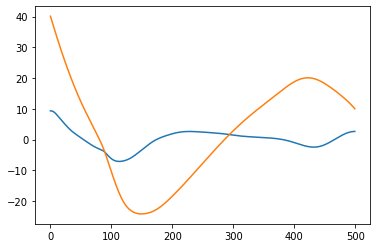

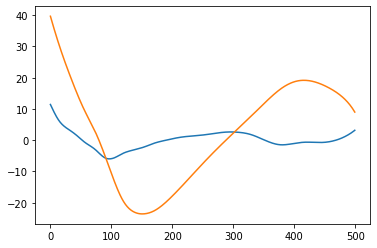

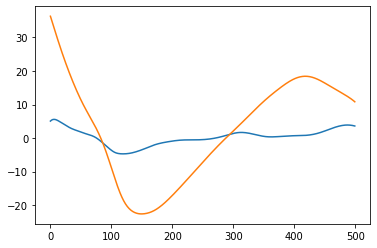

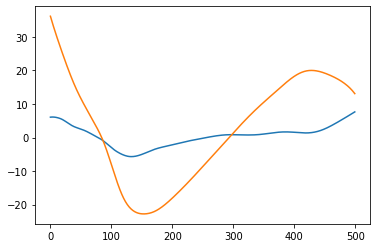

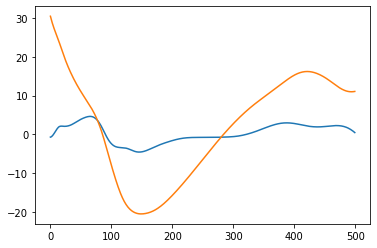

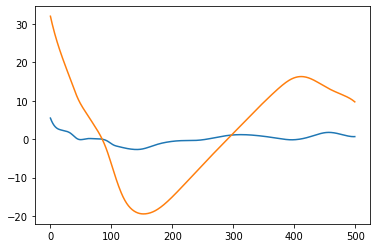

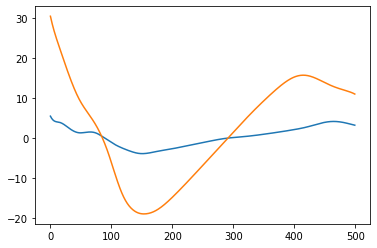

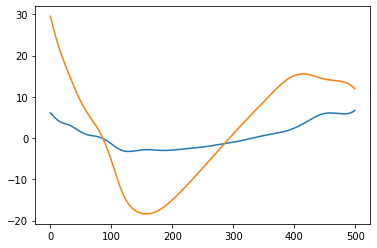

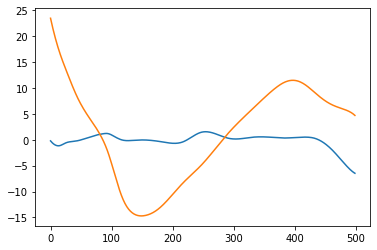

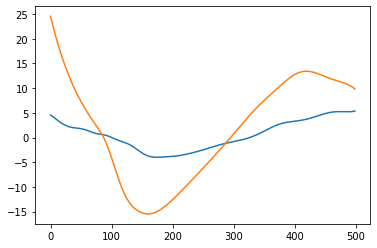

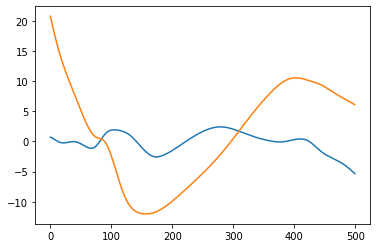

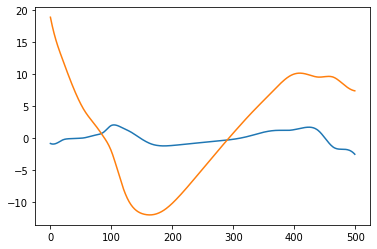

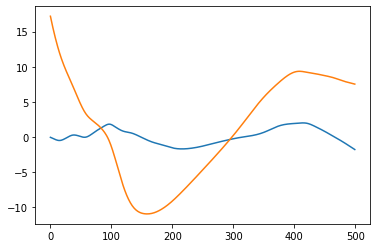

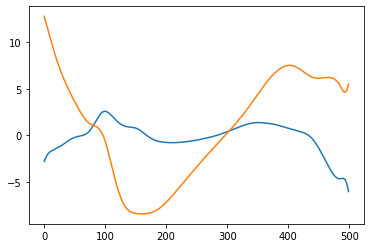

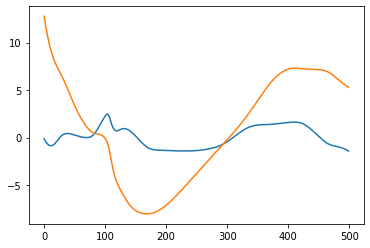

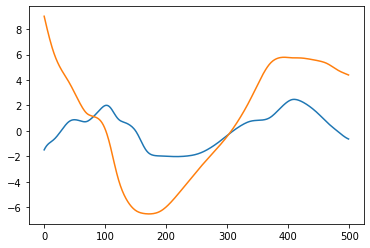

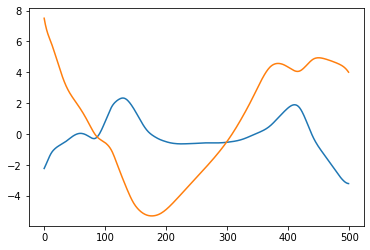

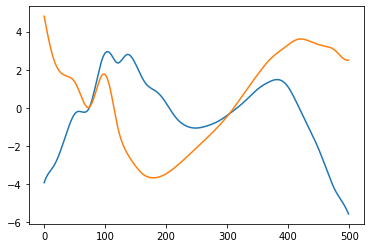

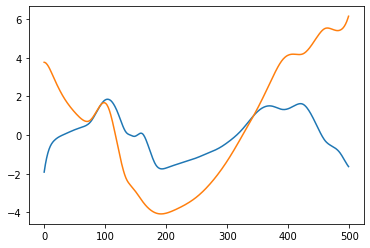

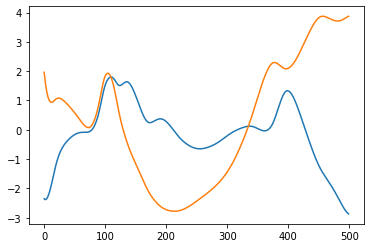

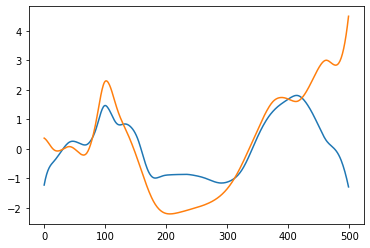

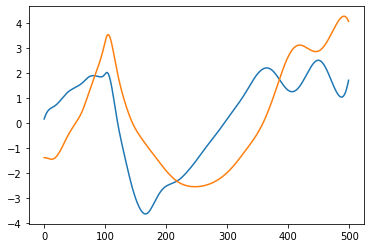

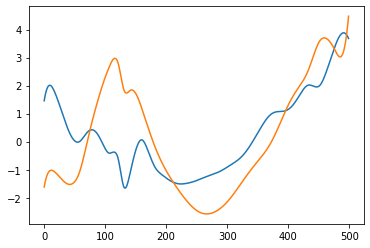

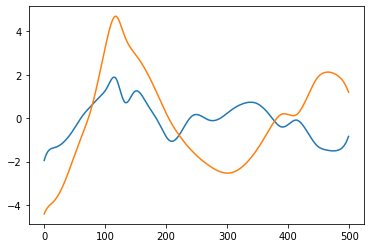

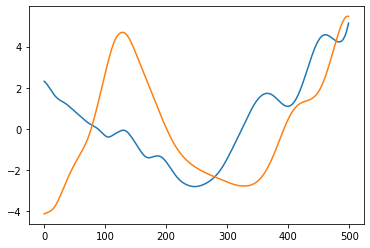

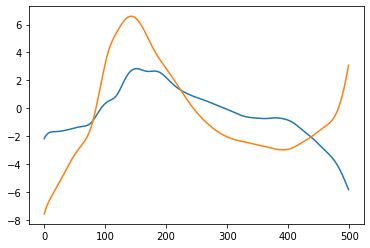

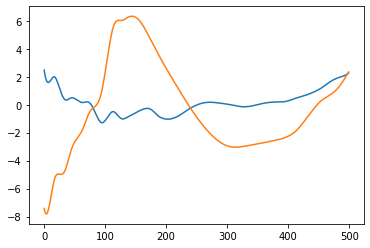

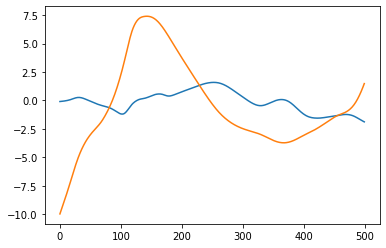

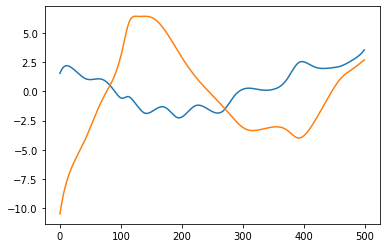

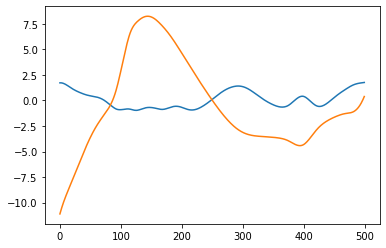

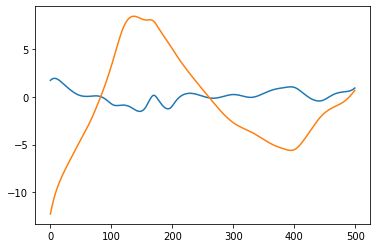

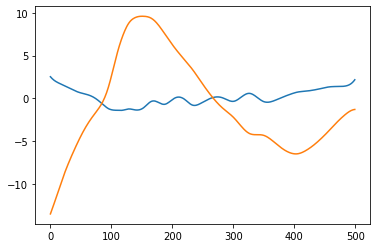

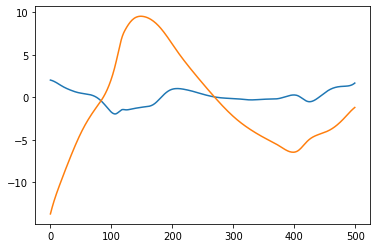

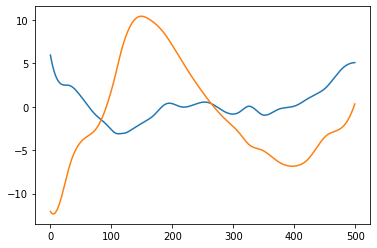

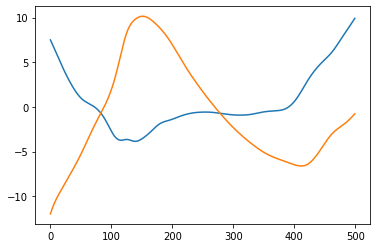

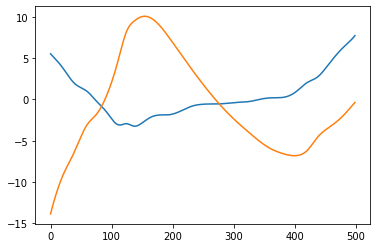

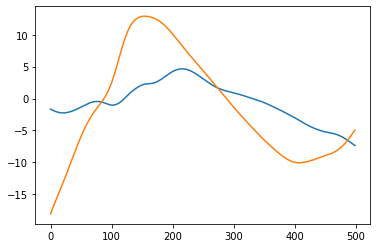

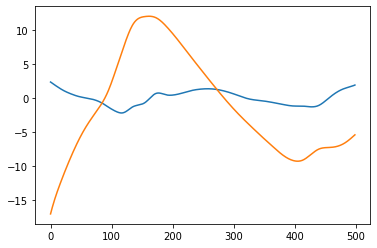

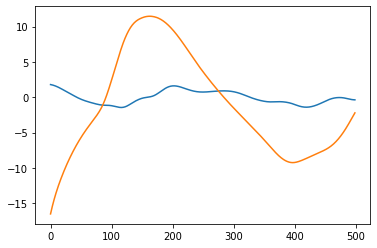

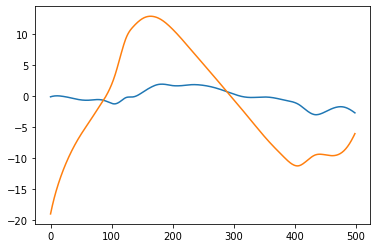

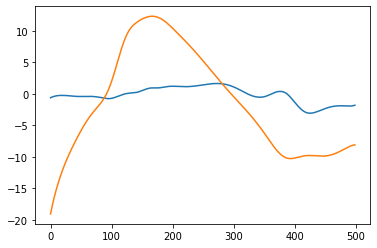

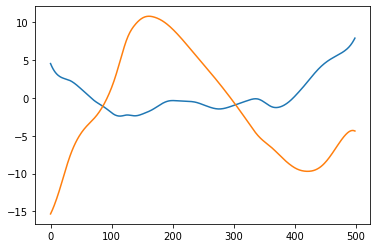

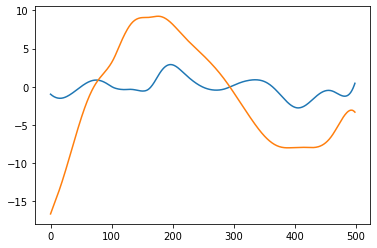

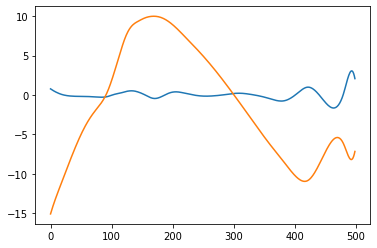

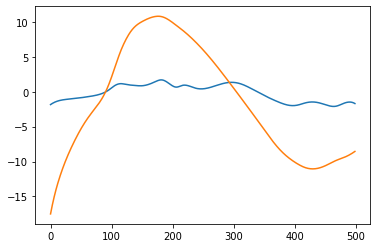

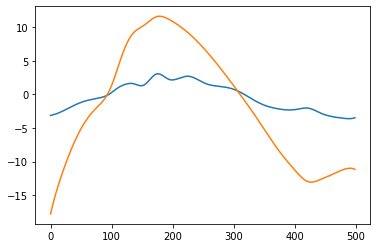

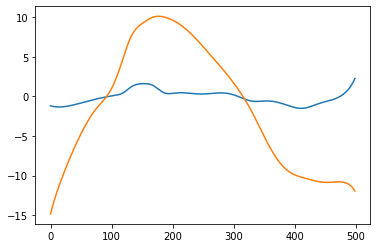

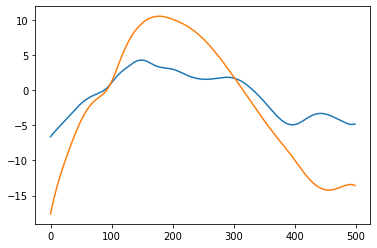

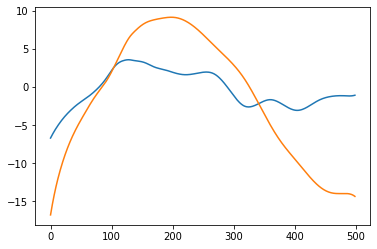

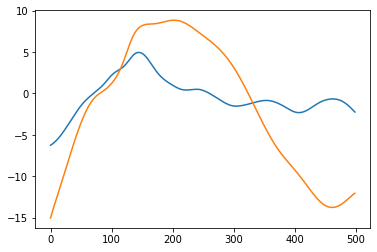

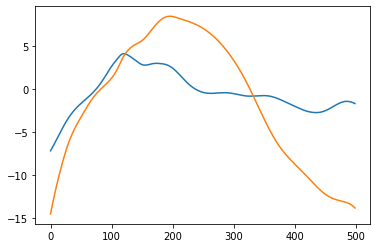

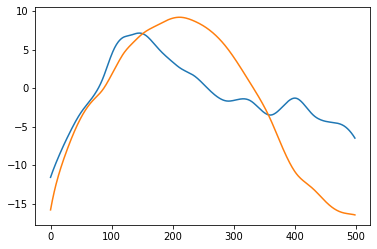

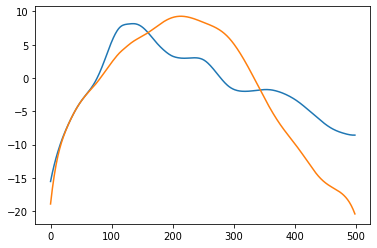

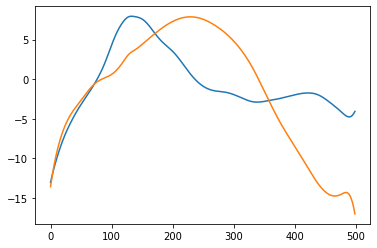

In [26]:
import matplotlib.pyplot as plt
for i in range(54):
  plt.figure(figsize=(6,4))
  plt.plot(Res[i,0,:])
  plt.plot(Res[i,1,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


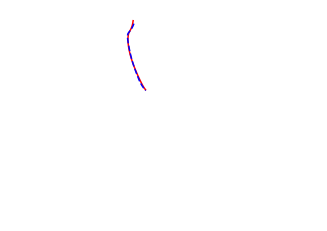

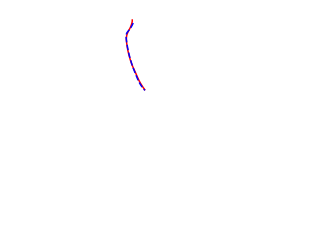

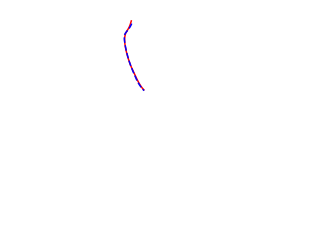

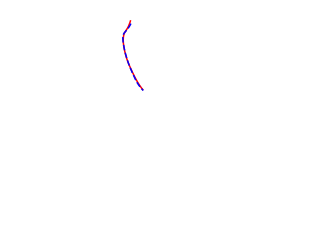

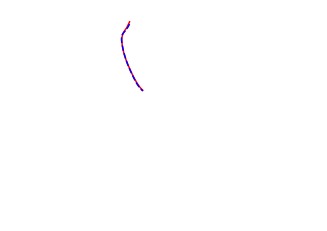

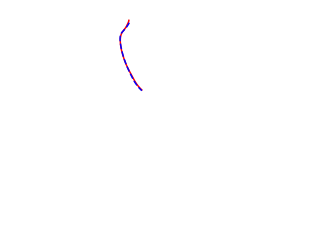

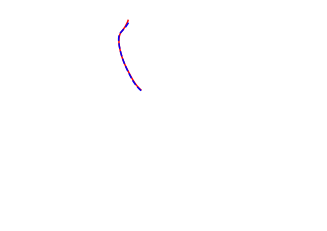

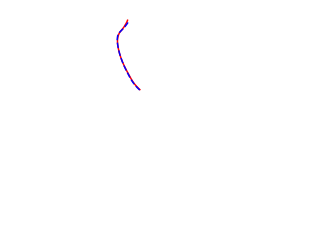

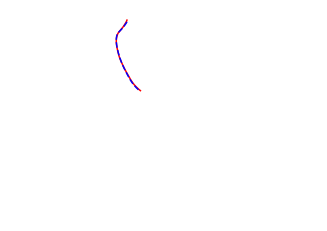

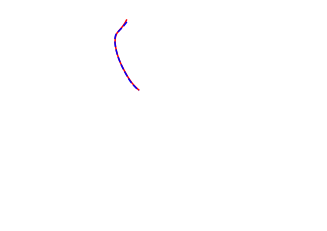

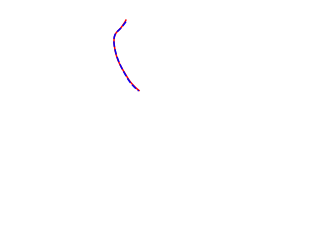

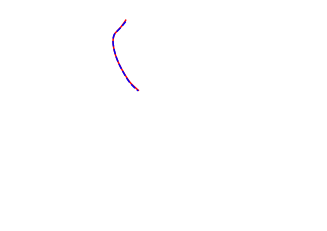

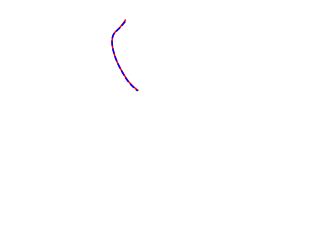

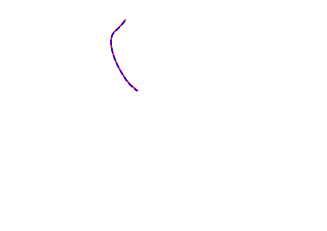

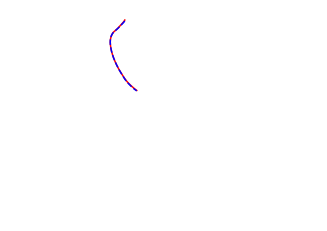

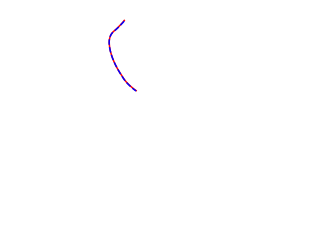

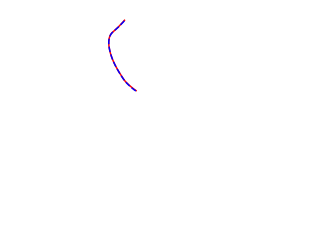

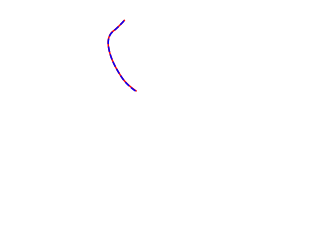

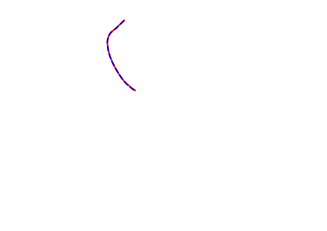

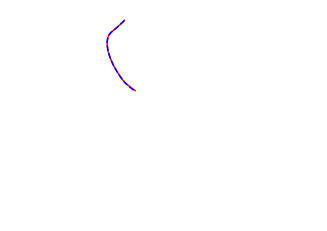

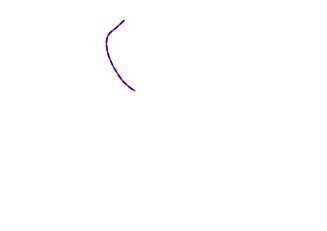

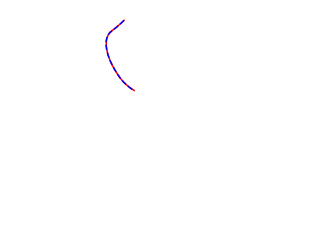

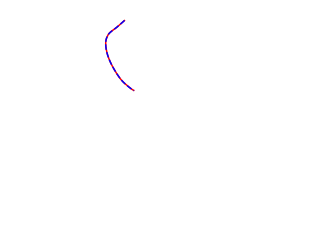

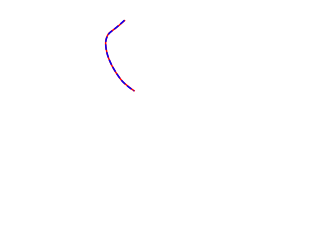

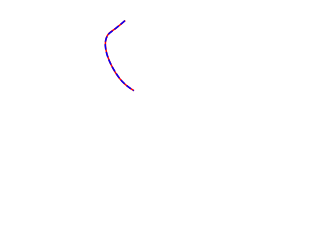

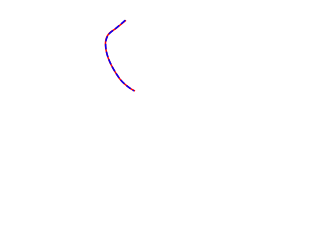

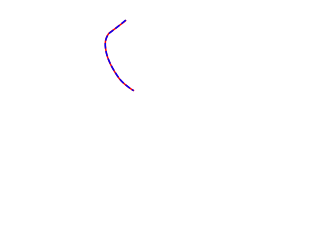

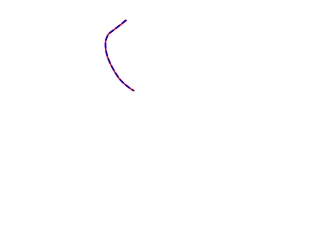

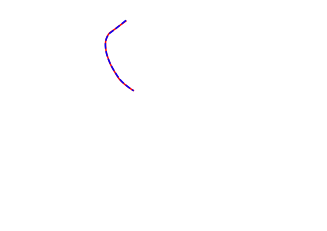

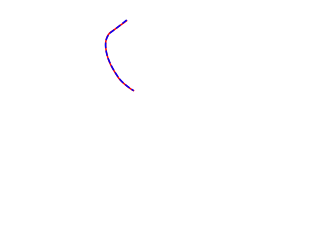

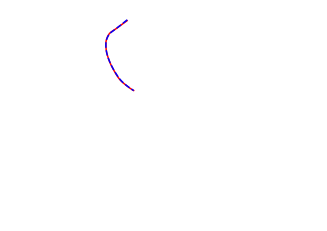

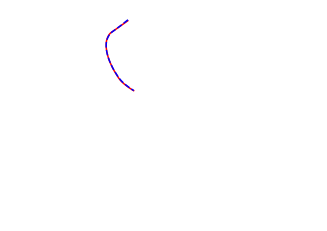

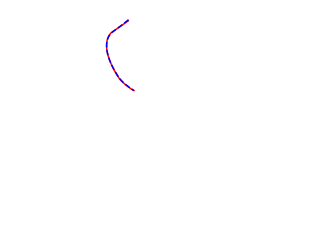

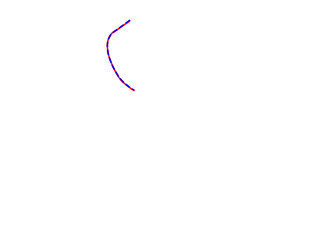

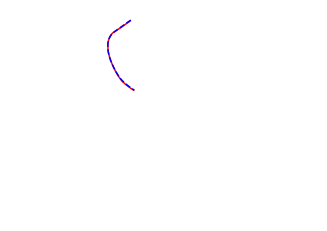

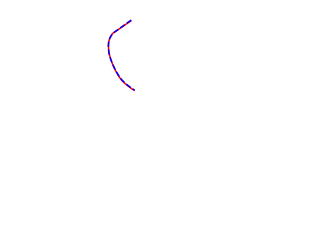

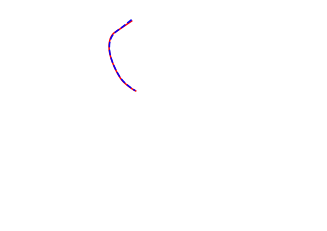

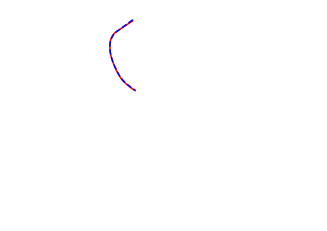

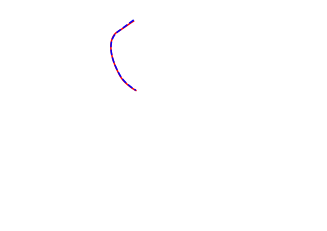

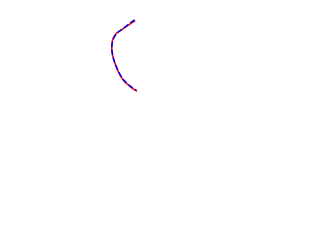

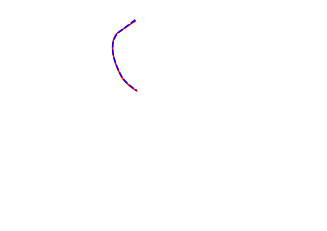

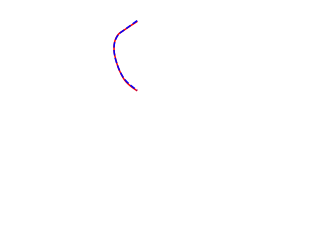

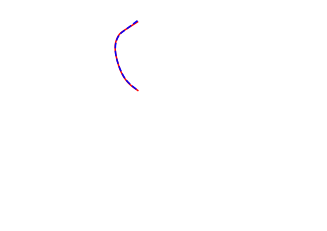

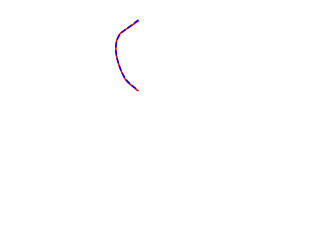

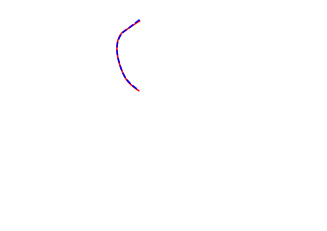

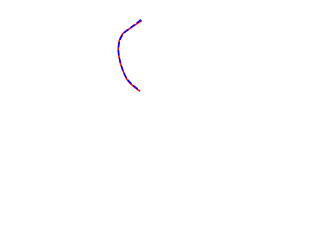

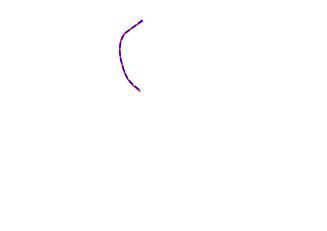

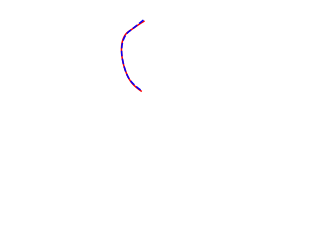

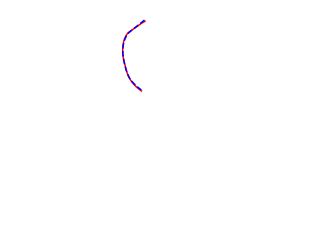

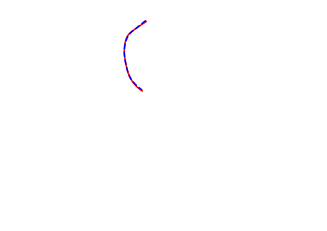

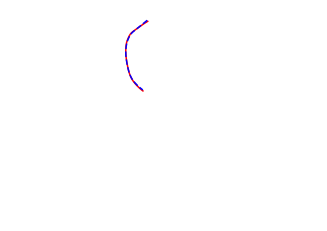

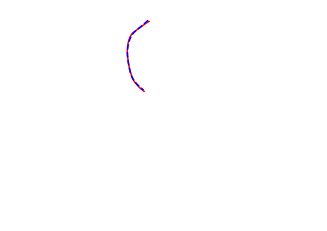

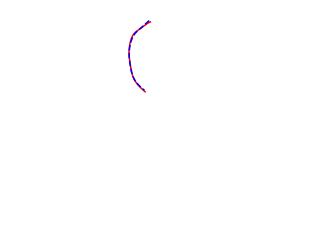

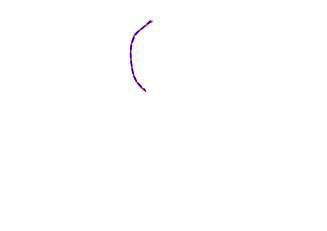

In [27]:
import matplotlib.pyplot as plt
for i in range(54):
  plt.figure(figsize=(6,4))
  plt.imshow(255*np.ones((2950,4250)).astype('uint8'),'gray',vmin=0,vmax=255)
  plt.plot(Point_cloud[i,:,0],Point_cloud[i,:,1],'r')
  plt.plot(rePro[i,0,:],rePro[i,1,:],'--b')
  plt.axis('off')

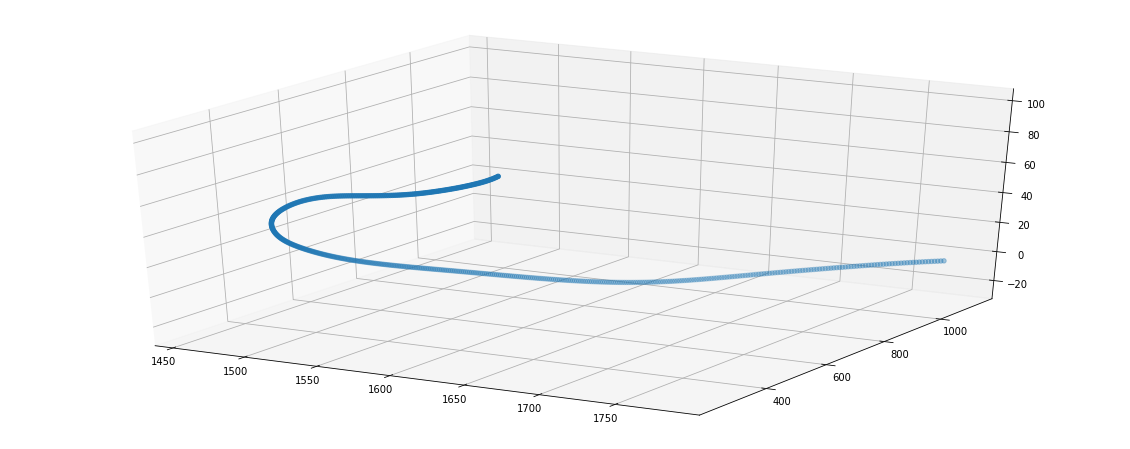

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Solved_Coord[0,:],Solved_Coord[1,:],Solved_Coord[2,:],'r-')

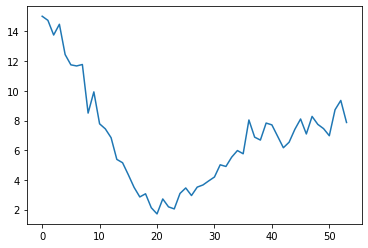

In [45]:
Res.shape
Err = np.zeros(54)
for i in range(54):
  Xsquare = np.square(Res[i,0,:])
  Ysquare = np.square(Res[i,1,:])
  Sum = Xsquare + Ysquare
  Err[i] = np.mean(np.sqrt(Sum)) 
plt.plot(Err)
plt.show()